### Análisis de sentimiento
A partir de una colección de tweets intentaremos predecir la connotación de cada uno de ellos: positivo, neutral o negativo.
El modelo se entrenara con una colección disponible de 1.600.000 tweets etiquetados.

Fuente del dataset: https://www.kaggle.com/kazanova/sentiment140


In [ ]:
!gdown 1ZE3tWxd4DhZD_96xxSRLwLNUN9DnftAA

Downloading...
From (original): https://drive.google.com/uc?id=1ZE3tWxd4DhZD_96xxSRLwLNUN9DnftAA
From (redirected): https://drive.google.com/uc?id=1ZE3tWxd4DhZD_96xxSRLwLNUN9DnftAA&confirm=t&uuid=1555be4d-7ac1-4e8c-89f2-2aa1681eb3a4
To: /content/trainingtweets.csv
100% 239M/239M [00:05<00:00, 39.8MB/s]


In [ ]:
import pandas as pd

columnas = ['target','ids','date','flag','user','text']
data = pd.read_csv('trainingtweets.csv', encoding = "latin-1", names=columnas)
# nos quedamos con una selección de 50.000 tweets aleatorios
data = data.sample(n=50000, random_state=42)
data = data.reset_index(drop=True) # reconstruimos los índices para que sean consecutivos
data.head()

,target,ids,date,flag,user,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


Los campos son los siguientes (extraido directamente de la documentación del dataset):
* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

Se usará sólo la columna del texto (contenido del tweet) y target (la etiqueta).

(array([24986.,     0.,     0.,     0., 25014.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

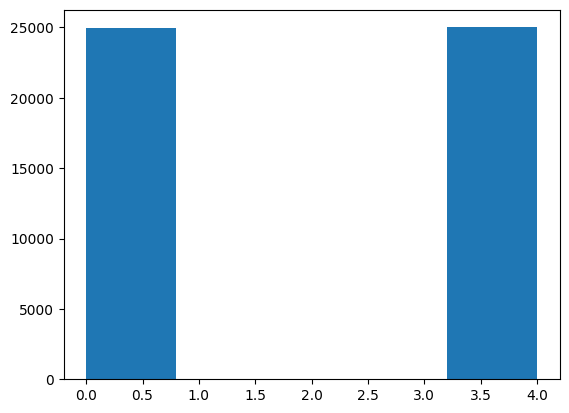

In [ ]:
from matplotlib import pyplot as plt

plt.hist(data['target'], bins=5)

Parece que el dataset sólo etiqueta los tweets positivos(=0) y los negativos(=4), ya que no hay ningún tweet etiquetado como neutral. Por una cuestión de convenienccia vamos a reasignar las etiquetas como 0=negativo y 1=positivo para simplificar la interpretación.

(array([24986.,     0., 25014.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

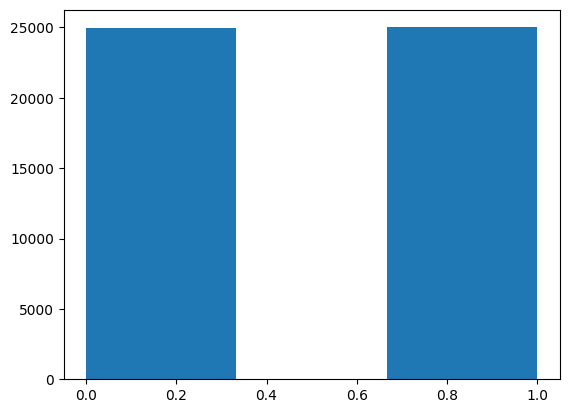

In [ ]:
# ahora la etiqueta para los tweets positivos es el 1
data.loc[data['target'] == 4, 'target'] = 1
plt.hist(data['target'], bins=3)

Las cantidades de tweets en ambas categorías está bastante equilibrada. Lo que nos permite avanzar sin tener que estratificar el dataset.

#### Prepro
Vamos a diseñar una red neuronal capaz de aprender si un texto es positivo o negativo (sentimiento). Para ello necesitamos codificar el texto de alguna manera para que la red neuronal, que trabaja con valores numéricos preferentemente, sea capaz de entenderlo.

En este caso trabajaremos con una técnica preentrenada que encontramos dentro del mundo del [*word2vec*](https://en.wikipedia.org/wiki/Word2vec).

La técnica consiste en codificar un conjunto amplio de palabras (corpus) como valores numéricos, es decir, creamos un índice en el que hacemos corresponder un valor a cada palabra.

Luego creamos una matriz con tantas filas como palabras haya en el corpus usando una codificación [one-hot](https://en.wikipedia.org/wiki/One-hot) (cada fila es un número binario dónde sólo hay un bit activo (hay un 1 y todo lo demás son 0).

In [ ]:
from keras.preprocessing.text import Tokenizer

# codificar tweets -> corpus -> one-hot
# con limit podemos limitar el número de palabras del corpus
def construir_corpus(tweets, limit=10000):
    corpus=[]
    i=0
    for t in tweets:
        if i>limit:
            break
        for w in t.lower().split():
            # si la palabra no está en el corpus y no empieza por @ (usuario twitter)
            if w[0] not in ('@') and 'http' not in w and len(w)>3 and not w in corpus:
                corpus.append(w)
                i=i+1

    # codificar palabras como enteros
    t = Tokenizer()
    t.fit_on_texts(corpus)
    encoded_corpus = t.texts_to_matrix(corpus, mode='count')

    return corpus[:limit], encoded_corpus[:limit]

In [ ]:
# Probamos con tres frases para confirmar que todo va bien
tweets = ['Sólo sé que no sé nada', 'Pienso luego existo', 'viva @socrates y @descartes']

corpus, encoded_corpus = construir_corpus(tweets)
print (corpus)
print (encoded_corpus)

['sólo', 'nada', 'pienso', 'luego', 'existo', 'viva']
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
# Ahora usamos los tweets del dataset
tweets = data['text']
corpus, encoded_corpus = construir_corpus(tweets)
print (corpus)
print (encoded_corpus) # esto no lo vamos a necesitar para nuestro ejemplo

['ahhh', 'hope', 'your', 'ok!!!', 'cool', 'have', 'tweet', 'apps', 'razr', 'know', 'just', 'family', 'drama.', 'lame.hey', 'next', 'time', 'hang', 'with', 'guys', 'like', 'sleepover', 'whatever,', 'call', 'school', 'email', "won't", 'open', 'geography', 'stuff', 'there', 'revise!', '*stupid', 'school*', 'upper', 'airways', 'problem', 'going', 'miss', "pastor's", 'sermon', 'faith...', 'lunch....dj', 'should', 'come', 'feeling', 'that?', 'gahh', 'noo!peyton', 'needs', 'live!this', 'horrible', 'thank', 'glad', 'product', 'review', 'site', 'enjoy', 'knitting', 'zach', 'makes', 'sitting', 'down!', 'grown', 'man!', 'word', '.........', 'kackered!', 'great', 'minds', 'think', 'alike', 'poorly', 'bed!', "that's", 'really', 'here', 'small', 'blizzard', 'also', 'cold', 'wind', 'blows...', 'lol,', 'calm', 'down.', '30day', 'loan', 'offer', 'only', '1500%', 'quite', 'sleepy', 'today,', 'wish', 'could', 'stay', 'today...but', 'last', 'year,', "let's", 'yeah', 'mathieu', 'totally', 'choked', 'well.'

Para codificar cada tweet, por cada palabra de la que esté compuesto, se pone un 1 en la posición correspondiente a cada palabra.

Una vez explicada la idea de cómo se codifica un tweet para que sea útil a la hora de alimentar una red neuronal, vamos a crear una función que codifique todo el conjunto de tweets.

Para codificar las etiquetas para el entrenamiento vamos a usar una codificación one-hot valiendonos de la función *to_categorical* de keras.

In [ ]:
# echo 1 > /proc/sys/vm/overcommit_memory

import numpy as np

from keras.utils import to_categorical

def codifica_tweets(tweets, corpus, corpus_size=10000):
    coded = np.zeros((len(tweets), corpus_size))
    for i, tweet_text in enumerate(tweets):
        words = tweet_text.lower().split()
        for w in words:
            if w in corpus:
                coded[i,corpus.index(w)] = 1

    return coded

x_train = codifica_tweets(data['text'], corpus)
y_train = to_categorical(data['target'])

In [ ]:
# barajamos el dataset
np.random.seed(42)
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]

# obtenemos el conjunto de validación
num_val = 10000
x_val = x_train[:num_val]
x_train = x_train[num_val:]
y_val = y_train[:num_val]
y_train = y_train[num_val:]

# obtenemos el conjunto de test
x_test = x_train[:num_val]
x_train = x_train[num_val:]
y_test = y_train[:num_val]
y_train = y_train[num_val:]

In [ ]:
print (x_train[0])
print (y_train[0])

[0. 0. 0. ... 0. 0. 0.]
[1. 0.]


Una vez preparados los datos, vamos a definir la arquitectura de la red neuronal.

Como los tweets se codifican en vectores de dimensión 10.000 y queremos que clasifique los tweets en dos categorías (positivos y negativos), nuestra red tendra 10.000 entradas y dos salidas en la última capa.

En esta última capa usaremos una función de activación de tipo softmax, que nos devolverá una distribución de probabilidad entre las dos salidas (una para la positiva y otra para la negativa), indicándonos cuál es la probabilidad de que corresponda a cada una de las dos clases.


In [ ]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

train_log = model.fit(x_train, y_train,
                     epochs=5, batch_size=512,
                     validation_data=(x_val, y_val))

Epoch 1/5
59/59 [==============================] - 6s 79ms/step - loss: 0.6484 - acc: 0.6698 - val_loss: 0.5964 - val_acc: 0.7137
Epoch 2/5
59/59 [==============================] - 5s 82ms/step - loss: 0.5492 - acc: 0.7438 - val_loss: 0.5498 - val_acc: 0.7265
Epoch 3/5
59/59 [==============================] - 5s 86ms/step - loss: 0.5017 - acc: 0.7653 - val_loss: 0.5439 - val_acc: 0.7284
Epoch 4/5
59/59 [==============================] - 5s 78ms/step - loss: 0.4776 - acc: 0.7784 - val_loss: 0.5488 - val_acc: 0.7298
Epoch 5/5
59/59 [==============================] - 3s 51ms/step - loss: 0.4613 - acc: 0.7875 - val_loss: 0.5528 - val_acc: 0.7277


Visualizar información del entrenamiento

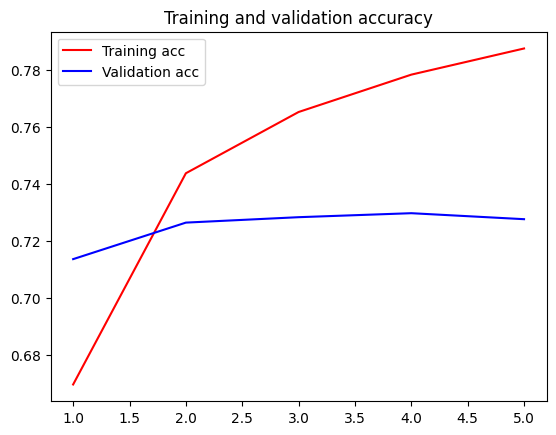

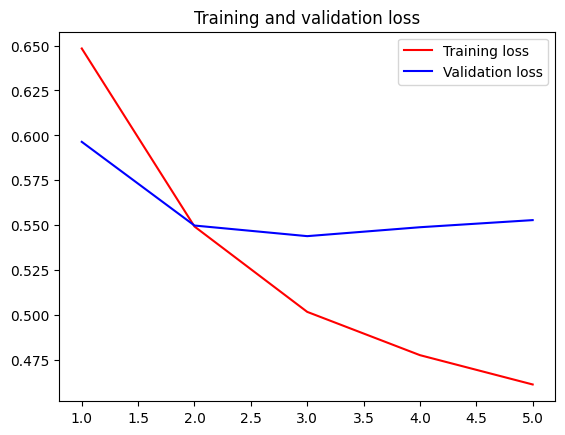

In [ ]:
import matplotlib.pyplot as plt

acc = train_log.history['acc']
val_acc = train_log.history['val_acc']
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Comprobamos cómo de bueno es el modelo con el conjunto de test

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

313/313 [==============================] - 2s 7ms/step - loss: 0.5487 - acc: 0.7289
0.7289000153541565


Prediciones sobre el conjunto de test

In [ ]:
predictions = model.predict(x_test)
print (np.argmax(predictions[1]))# clase más probable
print (y_test[1])


313/313 [==============================] - 2s 4ms/step
0
[1. 0.]


In [ ]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])